In [1]:
!bash init.sh

mkdir: cannot create directory ‘dataset’: File exists
mkdir: cannot create directory ‘np’: File exists


In [2]:
# Call Libraries
import torch
from torch import nn
from torch.nn.parameter import Parameter
from torch import distributions
import sys
sys.path.insert(0, '')
from scripts.utils import *
import numpy as np
torch.manual_seed(0)
np.random.seed(0)
import scanpy as sc
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
import os
from numpy.random import seed
# from tensorflow import set_random_seed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import pickle
import sys

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.dpi'] = 100

# from flow_ssl.realnvp.realnvp_toy import ToyRealNVP
from flow_ssl.realnvp.realnvp import RealNVPTabular
from flow_ssl.data import make_circles_ssl, make_moons_ssl, make_dataset_from_img, make_dataset_from_npz
from flow_ssl.distributions import SSLGaussMixture
from flow_ssl import FlowLoss

from itertools import chain

%load_ext autoreload
%autoreload 2

/home/anunay18021/.venv/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/anunay18021/.venv/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/anunay18021/.venv/lib/python3.8/site-packages/umap/distances.py:1086: NumbaDeprecationWa

scanpy==1.9.3 anndata==0.9.1 umap==0.5.3 numpy==1.23.5 scipy==1.10.1 pandas==1.5.3 scikit-learn==1.2.2 statsmodels==0.14.0 pynndescent==0.5.10


## Read input dataset

..Dont take SMART-seq data..they are TPM..

In [4]:
dataset_train = 'dataset/Bh.h5ad'
dataset_test = 'dataset/smartseq2.h5ad'
import sys  
sys.path.insert(0, '')

from scripts.utils import * 

adata_train=sc.read(dataset_train)
adata_test=sc.read(dataset_test)

print("Starting preprocessing...")
train_dic = preprocess(adata_train, min_cells=20,min_genes=50, get_hvgs = True, scale_and_hvgs = True)
test_dic = preprocess(adata_test, min_cells=0, min_genes=0)
print(len(intersection(adata_train.var.index, adata_test.var.index)))
list(adata_train.var.index)[0]

col= [i for i in train_dic['hvg'].index]

train_adata_pp =  train_dic['data']
print(train_dic['hvg'])
test_adata_pp =  test_dic['data'][:, intersection(col, test_dic['data'].var.index)]
train_adata_pp = train_dic['data'][:, intersection(col, train_dic['data'].var.index)]

train_df = train_adata_pp.to_df()
test_df = test_adata_pp.to_df()

## taking common genes
print("Taking common genes...")
final_columns = list(set(train_df.columns).intersection(set(test_df.columns)))
print('Common columns', len(final_columns))
final_columns = [i for i in final_columns if i != 'celltype'] 
train_df = train_df[final_columns]
test_df = test_df[final_columns]

y_train = train_adata_pp.obs.celltype.to_list()
y_test = test_adata_pp.obs.celltype.to_list()

X_train = train_df.to_numpy()
X_test = test_df.to_numpy()

labels = set(y_train)

mapping = get_mapping(y_train)

y_test = np.array(convert_y_to_mapping(y_test, mapping))

y_train = np.array(convert_y_to_mapping(y_train, mapping))

with open('dataset/np/X_train.pkl', 'wb') as fh:
    pickle.dump(X_train, fh)

with open('dataset/np/X_test.pkl', 'wb') as fh:
    pickle.dump(X_test, fh)

with open('dataset/np/y_test.pkl', 'wb') as fh:
    pickle.dump(y_test, fh)

with open('dataset/np/y_train.pkl', 'wb') as fh:
    pickle.dump(y_train, fh)

Starting preprocessing...
filtered out 5803 genes that are detected in less than 20 cells
normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/home/anunay18021/.venv/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)
14260
index
A2M       True
A4GALT    True
AADAC     True
AATK      True
ABCA4     True
          ... 
ZSCAN9    True
ZSWIM3    True
ZSWIM4    True
ZYX       True
pk        True
Name: highly_variable, Length: 3000, dtype: bool
Taking common genes...
Common columns 2975


## getting neighbours

In [5]:
def get_means(means_type, num_means=10, shape=(3, 32, 32), r=1, trainloader=None, device=None, net=None):

    D = np.prod(shape)
    means = torch.zeros((num_means, D)).to(device)

    if means_type == "pixel_const":
        for i in range(num_means):
            means[i, :] = r * (i-4)

    elif means_type == "split_dims":
        mean_portion = D // num_means
        for i in range(num_means):
            means[i, i*mean_portion:(i+1)*mean_portion] = r

    elif means_type == "random":
        for i in range(num_means):
            means[i] = r * torch.randn(D)

    else:
        raise NotImplementedError(means_type)

    return means

In [6]:
device = torch.device("cuda")

In [7]:
r = 3.5
means = torch.tensor([[-r, -r], [r, r]])

# r = 3.5
# n_classes = 2
means = get_means('random' , r=0.8*0.7, num_means=len(set(list(y_train))), trainloader=None, shape=(X_train.shape[1]), device=device).to(device)

prior = SSLGaussMixture(means=means, device=device)


flow = RealNVPTabular(num_coupling_layers=7, in_dim=X_train.shape[1], num_layers=3, hidden_dim=1024).to(device)
loss_fn = FlowLoss(prior).to(device)
# get_toy_nvp(D=2, prior=prior, device=None, inner_dim=256, coupling_layers_num=6, inner_layers=2)

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 47.54 GiB total capacity; 300.54 MiB already allocated; 12.00 MiB free; 302.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
torch.set_num_threads(10)

In [163]:
data = X_train
labels = y_train

In [117]:
lr_init = 2e-5
epochs = 1000

n_ul = np.sum(labels == -1)
n_l = np.shape(labels)[0] - n_ul
batch_size = n_l
print_freq = 100

#labeled_data = data[labels != -1]
#labeled_labels = labels[labels != -1]
#unlabeled_data = data[labels == -1]
#unlabeled_labels = labels[labels == -1]

labeled_data = data
labeled_labels = labels

optimizer = torch.optim.Adam([p for p in flow.parameters() if p.requires_grad==True], lr=lr_init,
                             weight_decay=1e-2)
step_size = 7500  # N.B. Can we c
for t in range(epochs):
    loss_total= []
#     batch_idx = np.random.choice(n_ul, size=batch_size)
#     batch_x, batch_y = unlabeled_data[batch_idx], unlabeled_labels[batch_idx]
    for m in range(max(1, batch_size//step_size)):
      batch_x = labeled_data[m*step_size: (m + 1)*step_size]
      batch_y = labeled_labels[m*step_size: (m + 1)*step_size]
      batch_x, batch_y = torch.from_numpy(batch_x.to_numpy()), torch.from_numpy(batch_y)
      batch_x, batch_y = batch_x.to(device), batch_y.to(device)
      z = flow(batch_x).to(device)
      sldj = flow.logdet().to(device)


      loss = loss_fn(z, sldj, batch_y)

      optimizer.zero_grad()
      loss.backward()#retain_graph=True)
      optimizer.step()

      loss_total.append(loss)

      if t == int(epochs * 0.5) or t == int(epochs * 0.8):
          for p in optimizer.param_groups:
              p["lr"] /= 10
    if t % print_freq == 0:
        print('iter %s:' % t, 'loss = %.3f' % float(sum(loss_total)/len(loss_total)),end="\n")
    if t % (print_freq*10) == 0:
        print()

iter 0: loss = 26446.404



iter 100: loss = 26287.371
iter 200: loss = 26058.732
iter 300: loss = 25817.941


In [ ]:
torch.save(flow.state_dict(), "flow_baron.pt")
torch.save(loss_fn.state_dict(), "loss_fn_baron.pt")

In [ ]:
flow.load_state_dict(torch.load("flow_baron.pt"))
loss_fn.load_state_dict(torch.load("loss_fn_baron.pt"))

## generating z space representation of nearest neighbours

In [67]:
def generate_data(freq, generate_upper_limit, data, x_dist = True, samples_to_generate = None):
  zs = []
  labels = []
  for i in samples_to_generate:
      z = loss_fn.prior.sample((samples_to_generate[i],), gaussian_id=i).cpu().numpy()
      labels.extend([rev_mapping[i]]*samples_to_generate[i])
      zs.append(z)
  zs = np.concatenate( zs, axis=0 )
  if x_dist:
    zs = flow.inverse(torch.from_numpy(zs).cuda().float()).cpu().detach().numpy()
  y_synthetic = labels
  return zs, y_synthetic

In [68]:
def remove_outliers(X, y):
    dist = get_avg_dist(X)
    mean = dist.mean()
    std = dist.std()
    index = np.where((mean - 3*std <= dist) & (mean + 3*std >= dist))
    X_new = X[index, :][0,:,:]
    Y_new = y[index]
    z_adata_pp = sc.AnnData(X=X_new, obs={"celltype": Y_new})
    z_adata_pp.obsm['X_tsne'] = X_new
    return z_adata_pp

In [69]:
def plot_tsne_data(X, labels, title):
  z_adata_pp = sc.AnnData(X=X, obs={"celltype": np.array(labels)})
  z_adata_pp.obsm['z_samples'] = X
  sc.tl.tsne(z_adata_pp, use_rep= 'z_samples', random_state=0)
  z_adata_pp = remove_outliers(z_adata_pp.obsm['X_tsne'], z_adata_pp.obs['celltype'].to_numpy())
  with plt.rc_context({'figure.figsize': (8, 8)}):
    sc.pl.tsne(z_adata_pp,
               color='celltype',
               add_outline=True,
               legend_fontsize=14,
               legend_fontoutline=2,
               frameon=False,
               title=title,
               size = 50,
               palette="tab20",
              )

In [70]:
def plot_umap_data(X, labels, title):
  z_adata_pp = sc.AnnData(X=X, obs={"celltype": np.array(labels)})
  z_adata_pp.obsm['z_samples'] = X
  z_adata_pp.obsm['X_embed'] = sc.tl.pca(X, svd_solver='arpack')
  #sc.tl.tsne(z_adata_pp, use_rep= 'z_samples', random_state=0)
  sc.pp.neighbors(z_adata_pp, n_neighbors=15, use_rep= 'X_embed', random_state=0)
  sc.tl.umap(z_adata_pp, random_state=0)
  #z_adata_pp = remove_outliers(z_adata_pp.obsm['X_embed'], z_adata_pp.obs['celltype'].to_numpy())
  with plt.rc_context({'figure.figsize': (8, 8)}):
    sc.pl.umap(z_adata_pp,
               color='celltype',
               add_outline=True,
               legend_fontsize=14,
               legend_fontoutline=2,
               frameon=False,
               title=title,
               size = 20,
               palette="tab20",
              )
    

computing tSNE
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:01:46)


/home/namratab/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/namratab/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/namratab/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


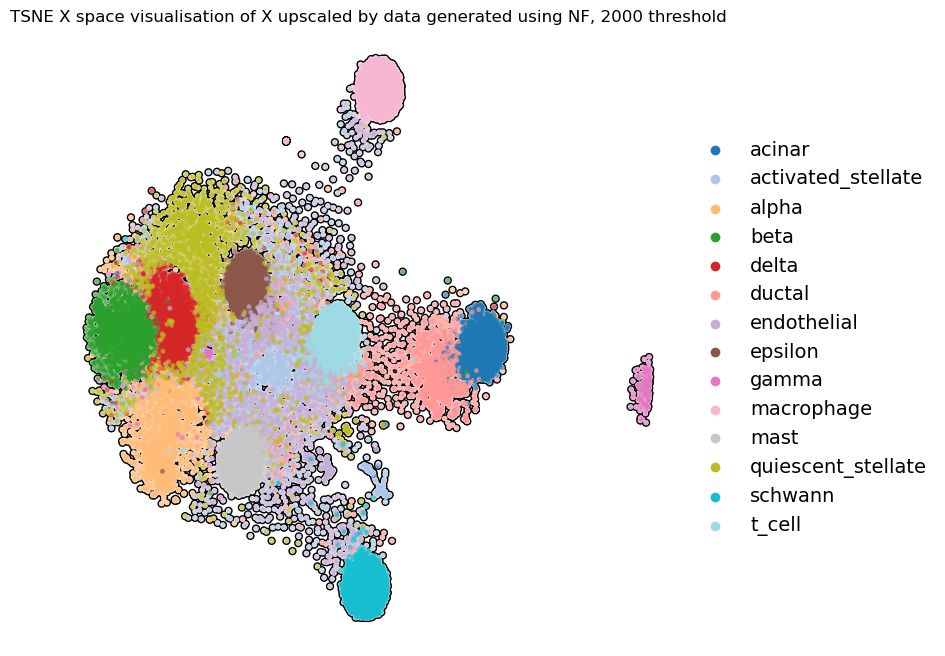

computing PCA
    with n_comps=50
    finished (0:00:05)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:12)


/home/namratab/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/namratab/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/namratab/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


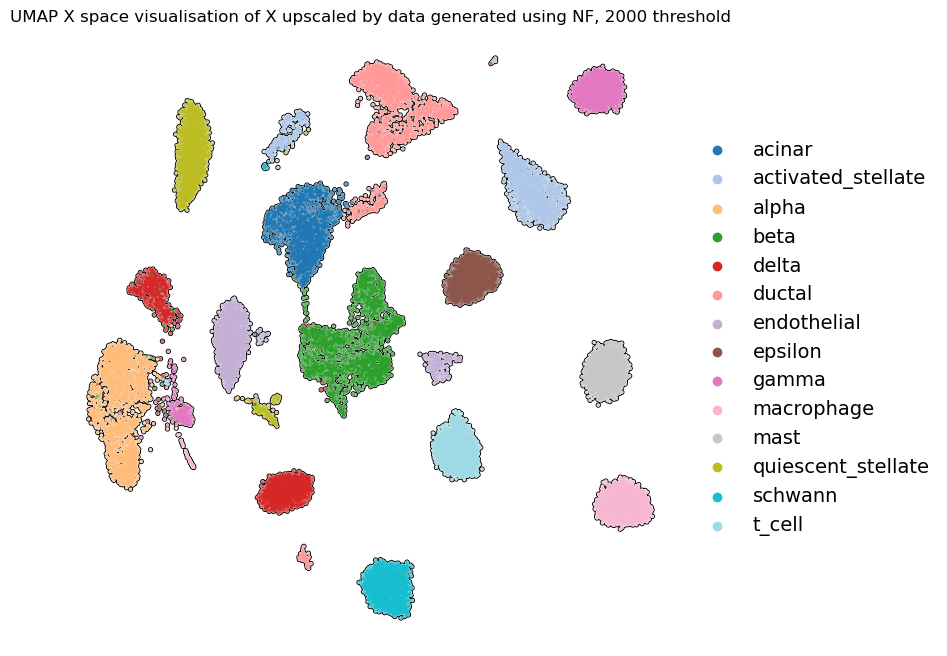

In [71]:
generated_data, generated_labels = generate_data(freq, 2000, adata.obs.celltype.to_list(), data, True)
plot_tsne_data(generated_data, generated_labels, "TSNE X space visualisation of X upscaled by data generated using NF, 2000 threshold")
plot_umap_data(generated_data, generated_labels, "UMAP X space visualisation of X upscaled by data generated using NF, 2000 threshold")

computing tSNE
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:02:58)


/home/namratab/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/namratab/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/namratab/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


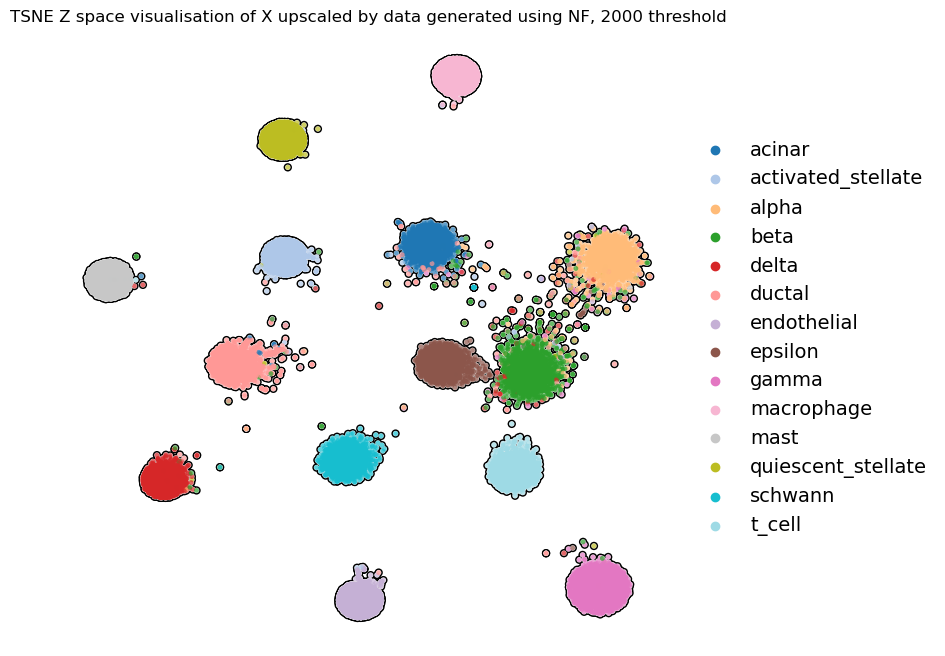

computing PCA
    with n_comps=50
    finished (0:00:16)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:07)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:42)


/home/namratab/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/namratab/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/namratab/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


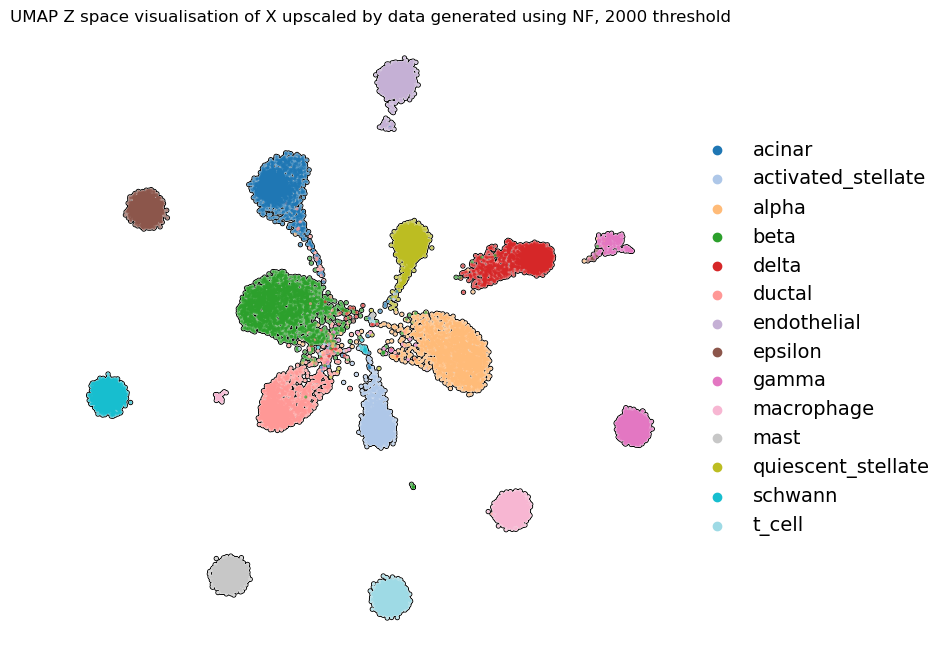

In [72]:
inv = flow(torch.from_numpy(data.to_numpy()).to(device)).cpu().detach().numpy()
generated_data, generated_labels = generate_data(freq, 2000, adata.obs.celltype.to_list(), inv, False)
plot_tsne_data(generated_data, generated_labels, "TSNE Z space visualisation of X upscaled by data generated using NF, 2000 threshold")
plot_umap_data(generated_data, generated_labels, "UMAP Z space visualisation of X upscaled by data generated using NF, 2000 threshold")

computing tSNE
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:02:59)


/home/namratab/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/namratab/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/namratab/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


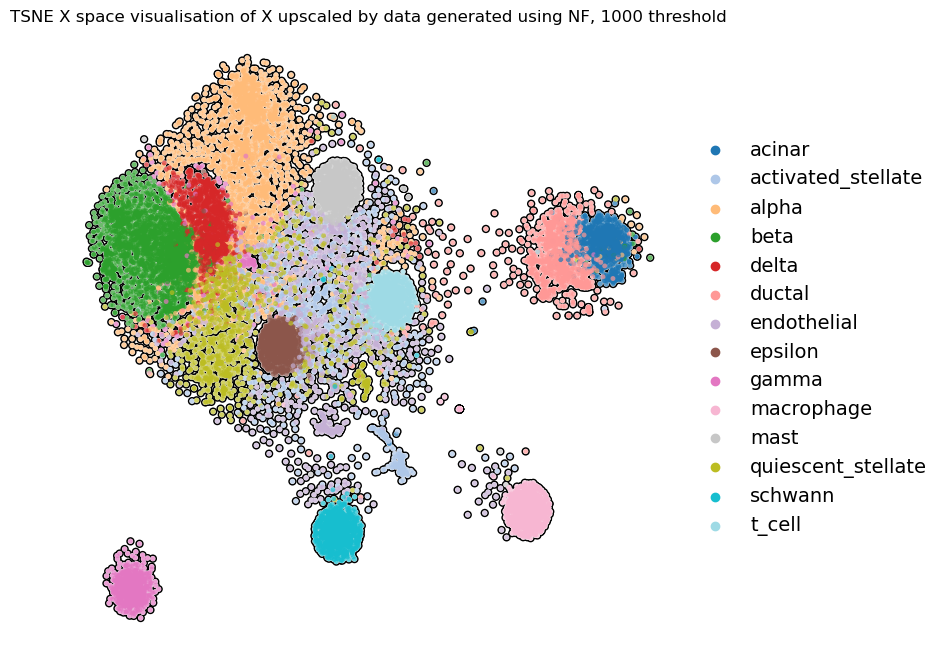

computing PCA
    with n_comps=50
    finished (0:00:10)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:22)


/home/namratab/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/namratab/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/namratab/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


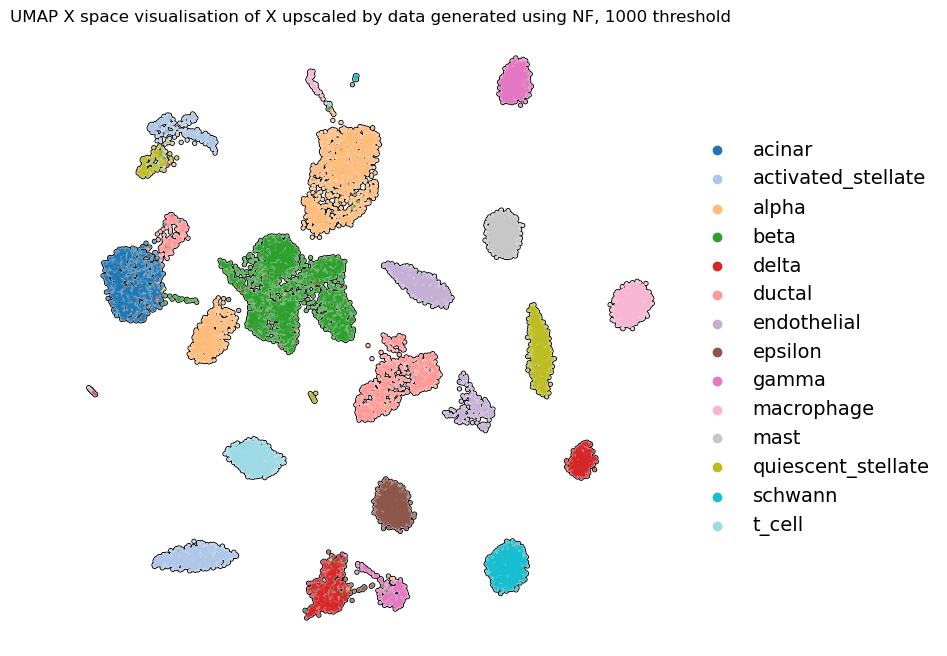

In [73]:
generated_data, generated_labels = generate_data(freq, 1000, adata.obs.celltype.to_list(), data, True)
plot_tsne_data(generated_data, generated_labels, "TSNE X space visualisation of X upscaled by data generated using NF, 1000 threshold")
plot_umap_data(generated_data, generated_labels, "UMAP X space visualisation of X upscaled by data generated using NF, 1000 threshold")

computing tSNE
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:02:27)


/home/namratab/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/namratab/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/namratab/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


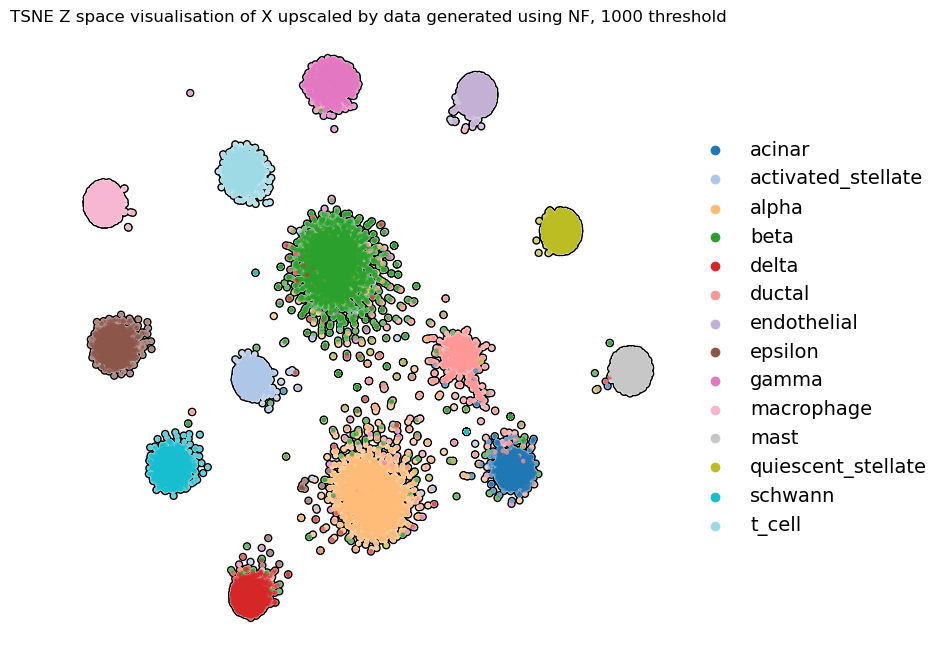

computing PCA
    with n_comps=50
    finished (0:00:09)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:47)


/home/namratab/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/namratab/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/namratab/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


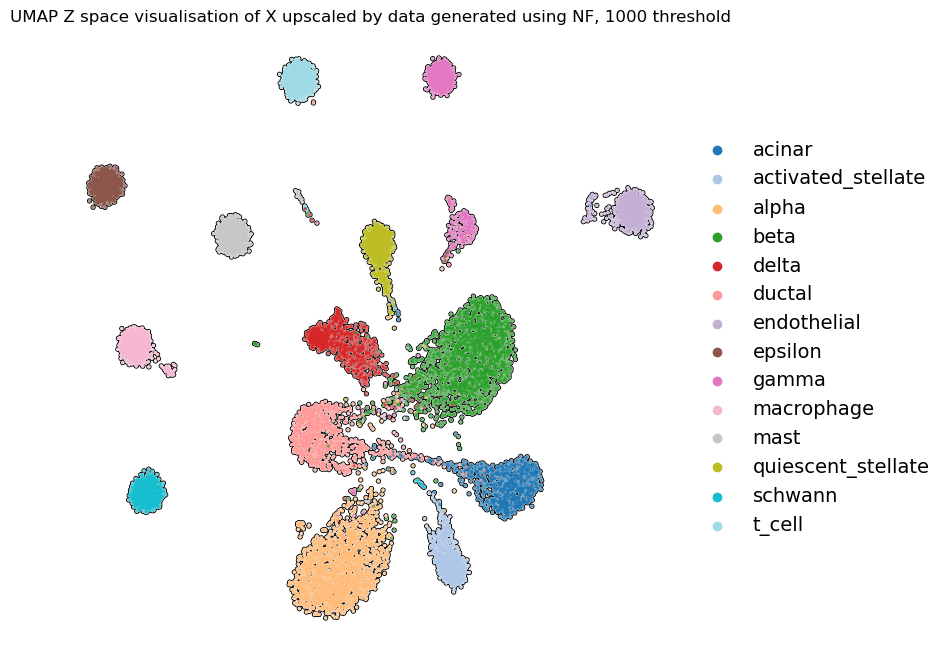

In [74]:
inv = flow(torch.from_numpy(data.to_numpy()).to(device)).cpu().detach().numpy()
generated_data, generated_labels = generate_data(freq, 1000, adata.obs.celltype.to_list(), inv, False)
plot_tsne_data(generated_data, generated_labels, "TSNE Z space visualisation of X upscaled by data generated using NF, 1000 threshold")
plot_umap_data(generated_data, generated_labels, "UMAP Z space visualisation of X upscaled by data generated using NF, 1000 threshold")

computing tSNE
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:02:35)


/home/namratab/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/namratab/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/namratab/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


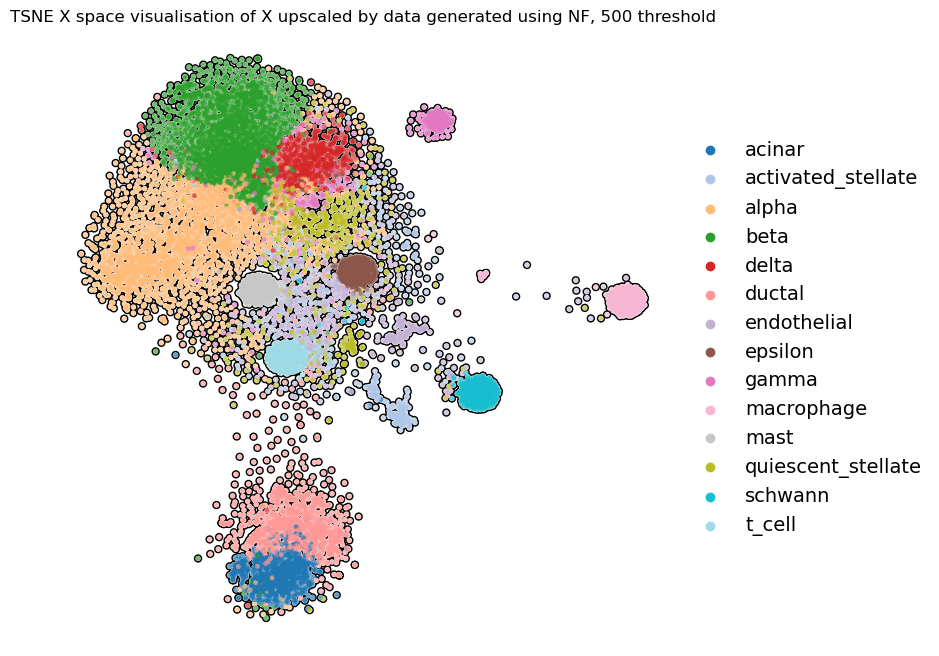

computing PCA
    with n_comps=50
    finished (0:00:07)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:16)


/home/namratab/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/namratab/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/namratab/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


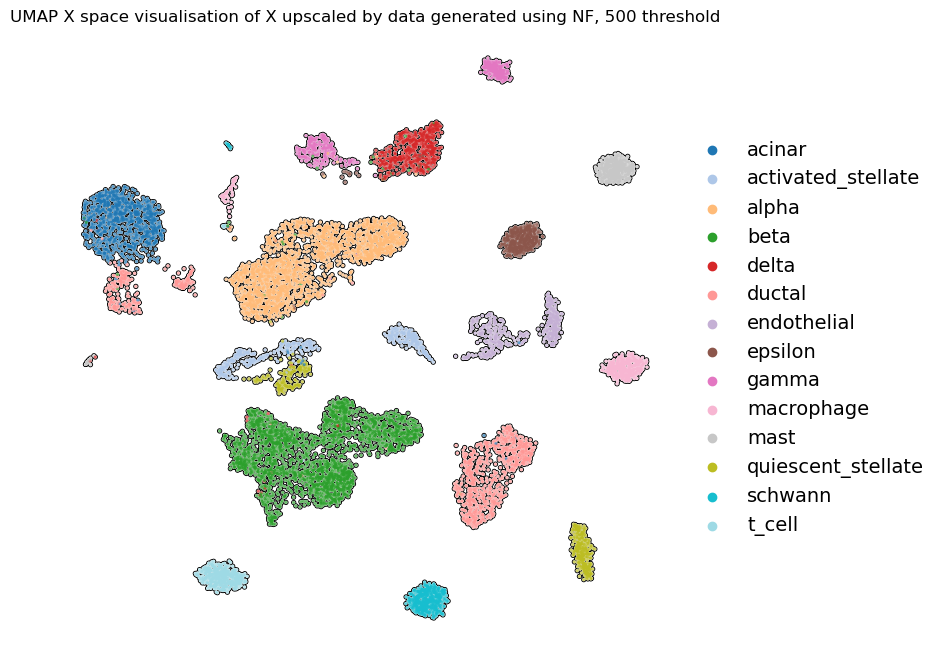

In [75]:
generated_data, generated_labels = generate_data(freq, 500, adata.obs.celltype.to_list(), data, True)
plot_tsne_data(generated_data, generated_labels, "TSNE X space visualisation of X upscaled by data generated using NF, 500 threshold")
plot_umap_data(generated_data, generated_labels, "UMAP X space visualisation of X upscaled by data generated using NF, 500 threshold")

computing tSNE
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:02:00)


/home/namratab/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/namratab/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/namratab/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


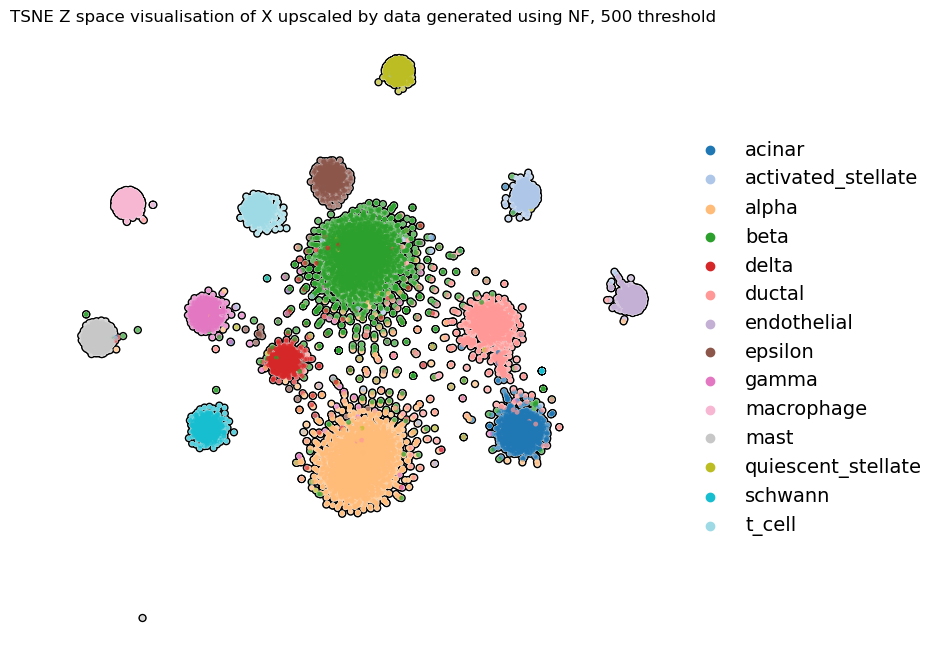

computing PCA
    with n_comps=50
    finished (0:00:08)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:21)


/home/namratab/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/namratab/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/namratab/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


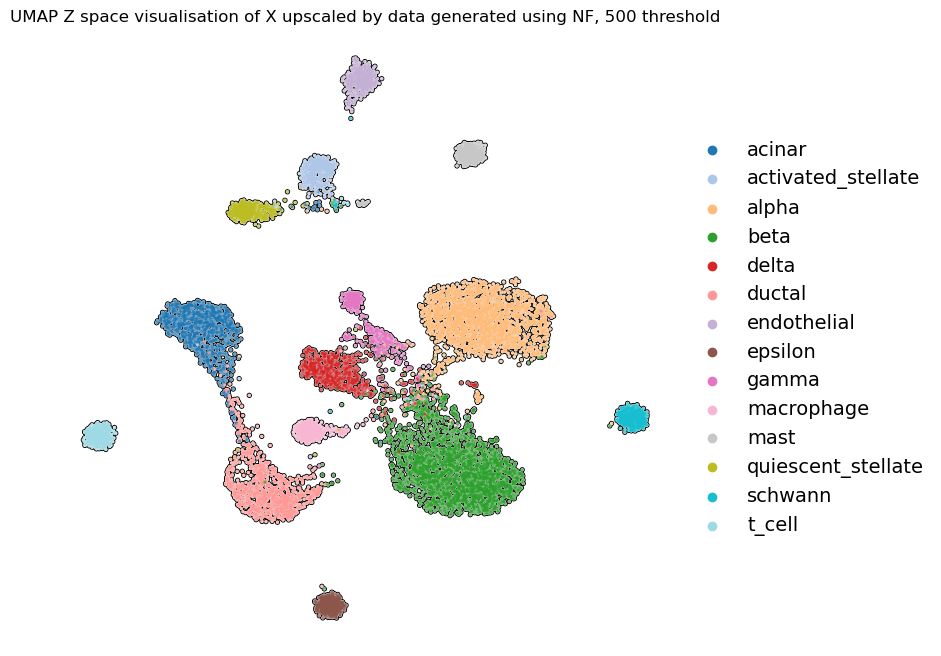

In [76]:
inv = flow(torch.from_numpy(data.to_numpy()).to(device)).cpu().detach().numpy()
generated_data, generated_labels = generate_data(freq, 500, adata.obs.celltype.to_list(), inv, False)
plot_tsne_data(generated_data, generated_labels, "TSNE Z space visualisation of X upscaled by data generated using NF, 500 threshold")
plot_umap_data(generated_data, generated_labels, "UMAP Z space visualisation of X upscaled by data generated using NF, 500 threshold")

computing tSNE
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:01:46)


/home/namratab/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/namratab/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/namratab/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


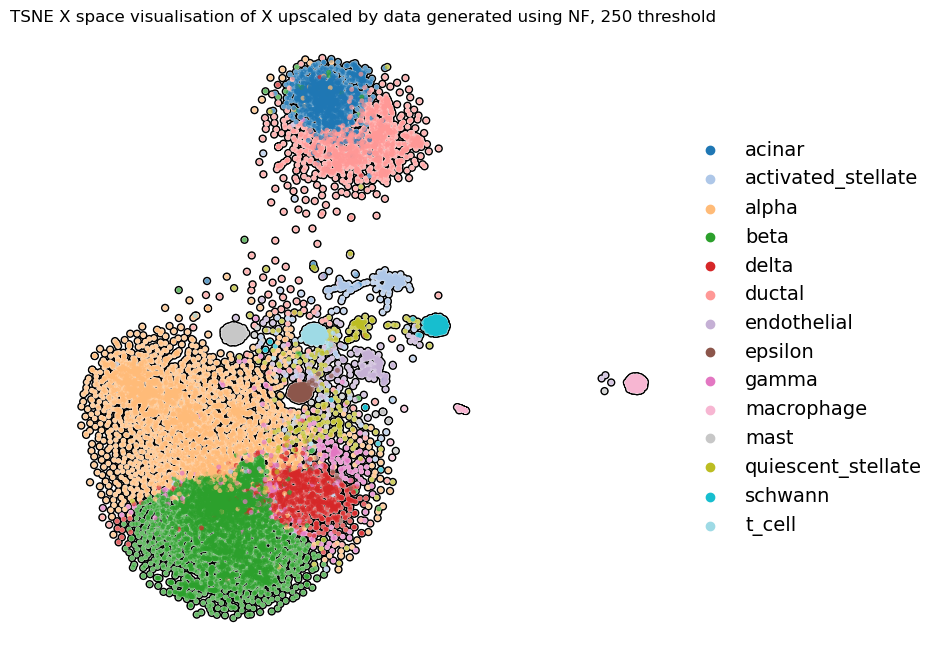

computing PCA
    with n_comps=50
    finished (0:00:06)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:24)


/home/namratab/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/namratab/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/namratab/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


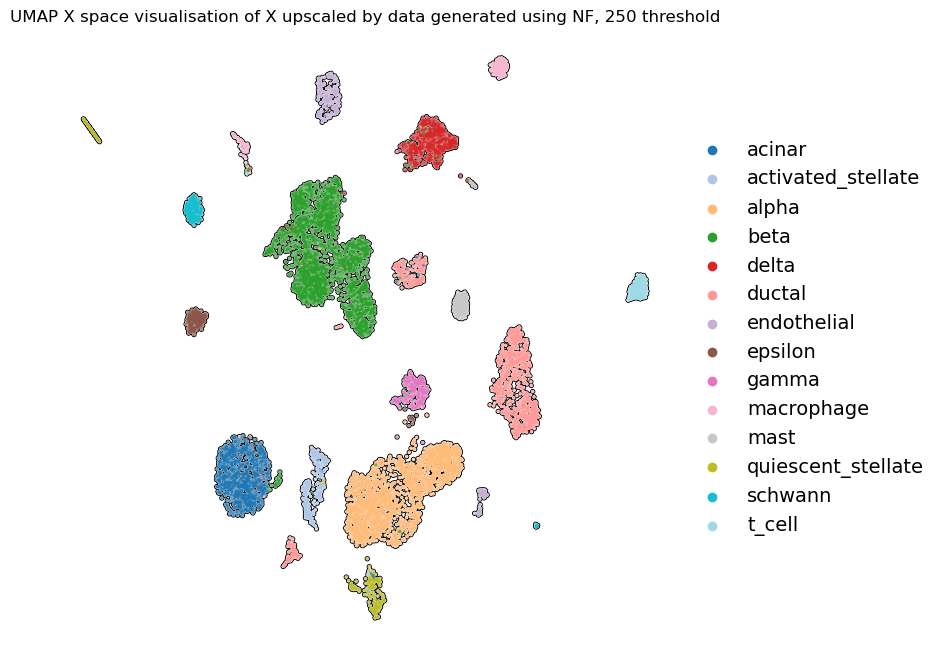

In [77]:
generated_data, generated_labels = generate_data(freq, 250, adata.obs.celltype.to_list(), data, True)
plot_tsne_data(generated_data, generated_labels, "TSNE X space visualisation of X upscaled by data generated using NF, 250 threshold")
plot_umap_data(generated_data, generated_labels, "UMAP X space visualisation of X upscaled by data generated using NF, 250 threshold")

computing tSNE
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:01:50)


/home/namratab/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/namratab/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/namratab/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


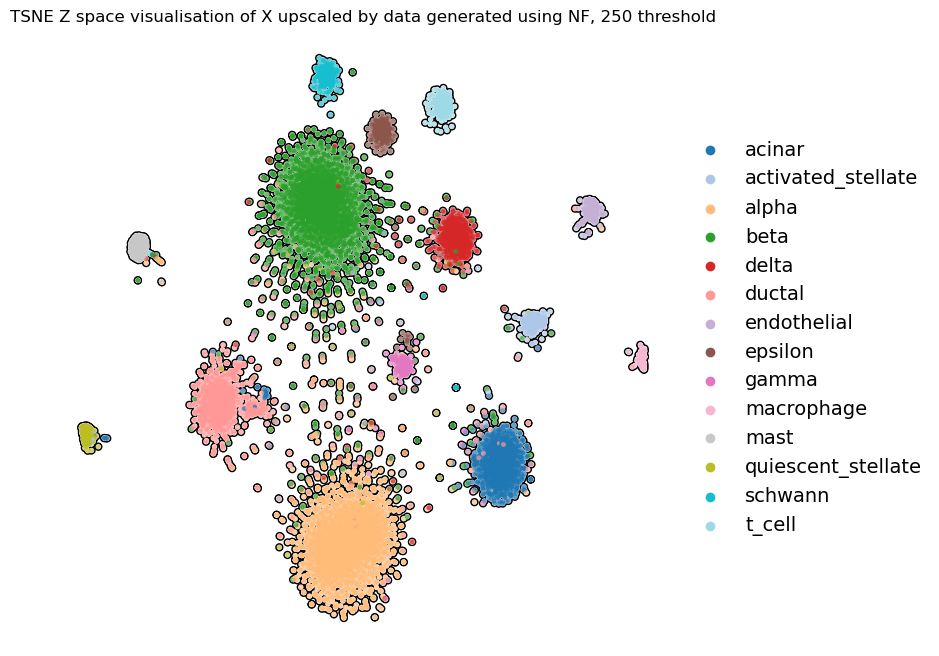

computing PCA
    with n_comps=50
    finished (0:00:07)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:26)


/home/namratab/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/namratab/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/namratab/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


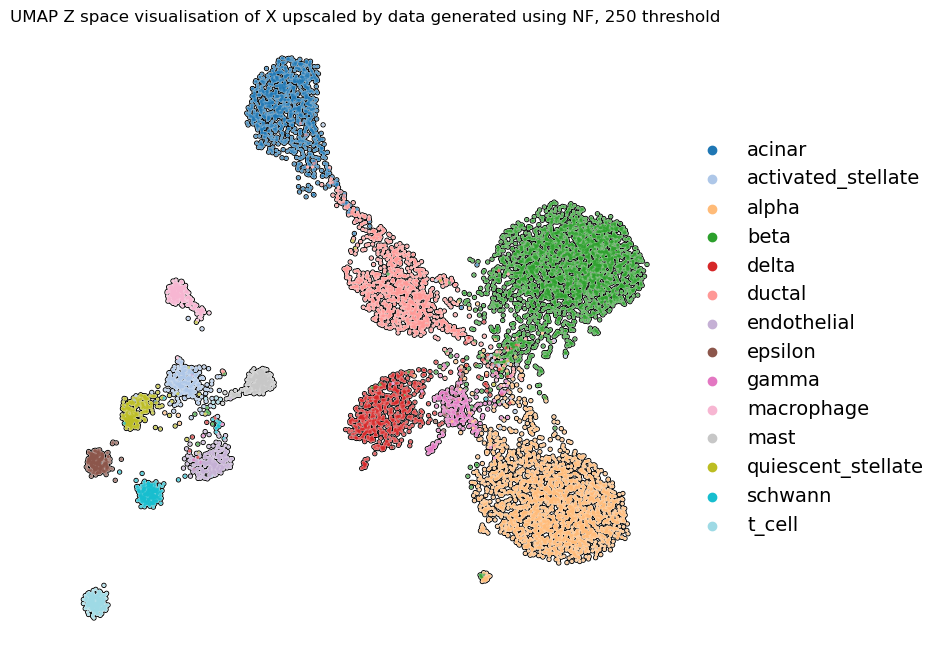

In [78]:
inv = flow(torch.from_numpy(data.to_numpy()).to(device)).cpu().detach().numpy()
generated_data, generated_labels = generate_data(freq, 250, adata.obs.celltype.to_list(), inv, False)
plot_tsne_data(generated_data, generated_labels, "TSNE Z space visualisation of X upscaled by data generated using NF, 250 threshold")
plot_umap_data(generated_data, generated_labels, "UMAP Z space visualisation of X upscaled by data generated using NF, 250 threshold")

computing tSNE
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:01:35)


/home/namratab/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/namratab/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/namratab/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


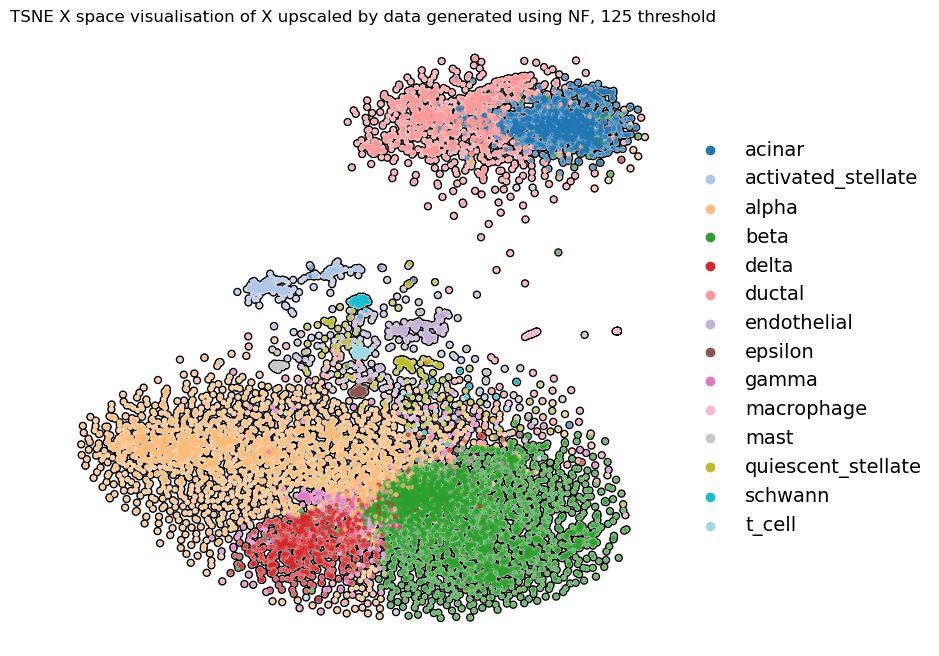

computing PCA
    with n_comps=50
    finished (0:00:03)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP


In [ ]:
generated_data, generated_labels = generate_data(freq, 125, adata.obs.celltype.to_list(), data, True)
plot_tsne_data(generated_data, generated_labels, "TSNE X space visualisation of X upscaled by data generated using NF, 125 threshold")
plot_umap_data(generated_data, generated_labels, "UMAP X space visualisation of X upscaled by data generated using NF, 125 threshold")

In [ ]:
inv = flow(torch.from_numpy(data.to_numpy()).to(device)).cpu().detach().numpy()
generated_data, generated_labels = generate_data(freq, 125, adata.obs.celltype.to_list(), inv, False)
plot_tsne_data(generated_data, generated_labels, "TSNE Z space visualisation of X upscaled by data generated using NF, 125 threshold")
plot_umap_data(generated_data, generated_labels, "UMAP Z space visualisation of X upscaled by data generated using NF, 125 threshold")